# **LONG SHORT TERM MEMORY FOR P&G STOCK**

**IMPORTING IMPORTANT LIBRARIES**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
import preprocessing 
import sklearn
import backtest_functions as bt

Using TensorFlow backend.


**User defined functions for data extraction and transformation**

In [2]:
# loading dataset
def getData(strt_date, end_date):
    FF = pd.read_csv("../input/fulldata/Fulldata_2.csv")
    # Date format change
    FF["Date"] = pd.to_datetime(FF["Date"])
    # Data selection
    df = FF[(FF["Date"] >= strt_date) & (FF["Date"] <= end_date)]
    # Reset Index
    df = df.reset_index()
    df = df.drop(["index"], axis =1)
    # Average Column and no. of days calculations
    df["Average"] = (FF["Open"] + 2*FF["High"] + FF["Close"])/4
    df["Days"] = range(1,df.shape[0]+1)
    df["beta_0"] = 1
    return df

In [3]:
# FUNCTION TO CREATE 1D DATA INTO TIME SERIES DATASET
def new_dataset(dataset, step_size):
    data_X, data_Y = [], []
    for i in range(len(dataset)-step_size-1):
        a = dataset[i:(i+step_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + step_size, 0])
    return np.array(data_X), np.array(data_Y)

# THIS FUNCTION CAN BE USED TO CREATE A TIME SERIES DATASET FROM ANY 1D ARRAY

**Plot of P&G stock index values**

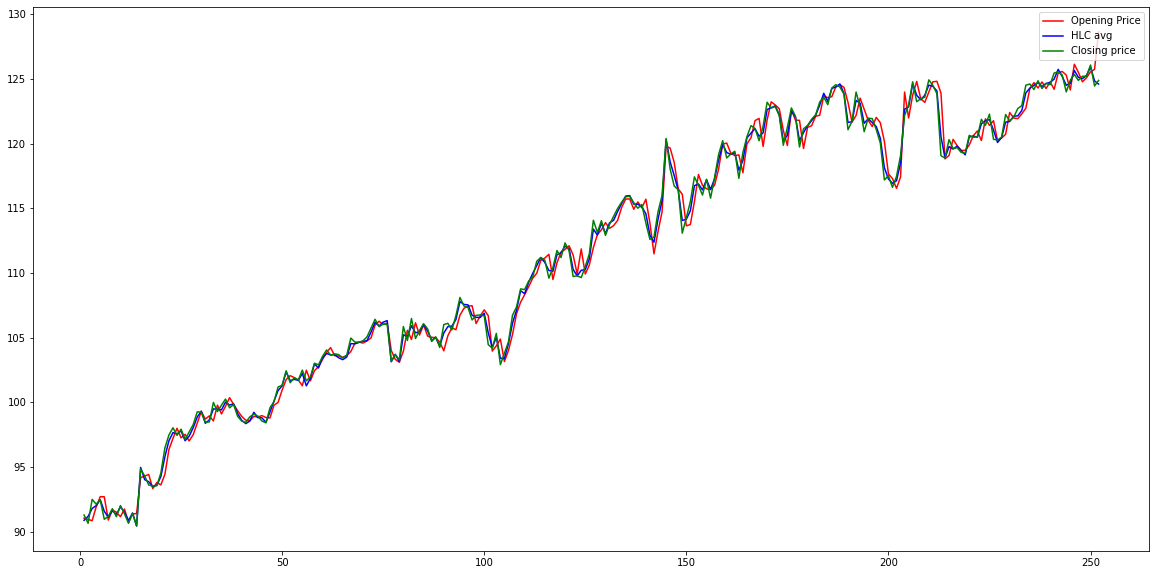

In [4]:
# FOR REPRODUCIBILITY
np.random.seed(7)

train_start_date = "2019-01-01"
train_end_date =  "2019-10-31"
test_start_date = "2019-11-01"
test_end_date = "2019-12-31"

# IMPORTING DATASET 

df = getData(train_start_date,test_end_date)

dataset = df[['Open','High', 'Low', 'Close']]
#dataset = dataset.reindex(index = dataset.index[::-1])

# CREATING OWN INDEX FOR FLEXIBILITY
obs = np.arange(1, len(dataset) + 1, 1)

# TAKING DIFFERENT INDICATORS FOR PREDICTION
OHLC_avg = dataset['Open']
HLC_avg = dataset[['High', 'Low', 'Close']].mean(axis = 1)
close_val = dataset[['Close']]

# PLOTTING ALL INDICATORS IN ONE PLOT
plt.figure(figsize=(20,10))
plt.plot(obs, OHLC_avg, 'r', label = 'Opening Price')
plt.plot(obs, HLC_avg, 'b', label = 'HLC avg')
plt.plot(obs, close_val, 'g', label = 'Closing price')
plt.legend(loc = 'upper right')
plt.show()

**Train - Test Split and Data Transformation**

In [5]:
# PREPARATION OF TIME SERIES DATASE
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) # 1664
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)

# TRAIN-TEST SPLIT
train_OHLC = int(len(df[(df["Date"] >= train_start_date) & (df["Date"] <= train_end_date)]))
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

# TIME-SERIES DATASET (FOR TIME T, VALUES FOR TIME T+1)
trainX, trainY = new_dataset(train_OHLC, 1)
testX, testY = new_dataset(test_OHLC, 1)

# RESHAPING TRAIN AND TEST DATA
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
step_size = 1

**LSTM Model Training and Prediction**

In [6]:
# LSTM MODEL
model = Sequential()
model.add(LSTM(32, input_shape=(1, step_size), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))
model.add(Activation('linear'))

# MODEL COMPILING AND TRAINING
model.compile(loss='mean_squared_error', optimizer='adagrad') # Try SGD, adam, adagrad and compare!!!
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)

# PREDICTION
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

Epoch 1/5
 - 2s - loss: 0.0394
Epoch 2/5
 - 1s - loss: 0.0078
Epoch 3/5
 - 1s - loss: 0.0030
Epoch 4/5
 - 1s - loss: 0.0020
Epoch 5/5
 - 1s - loss: 0.0017


**Model Validation using RMSE**

In [7]:
# DE-NORMALIZING FOR PLOTTING
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])


# TRAINING RMSE
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train RMSE: %.2f' % (trainScore))

# TEST RMSE
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test RMSE: %.2f' % (testScore))

Train RMSE: 1.51
Test RMSE: 1.47


**Plot of Predicted and Original Opening Price**

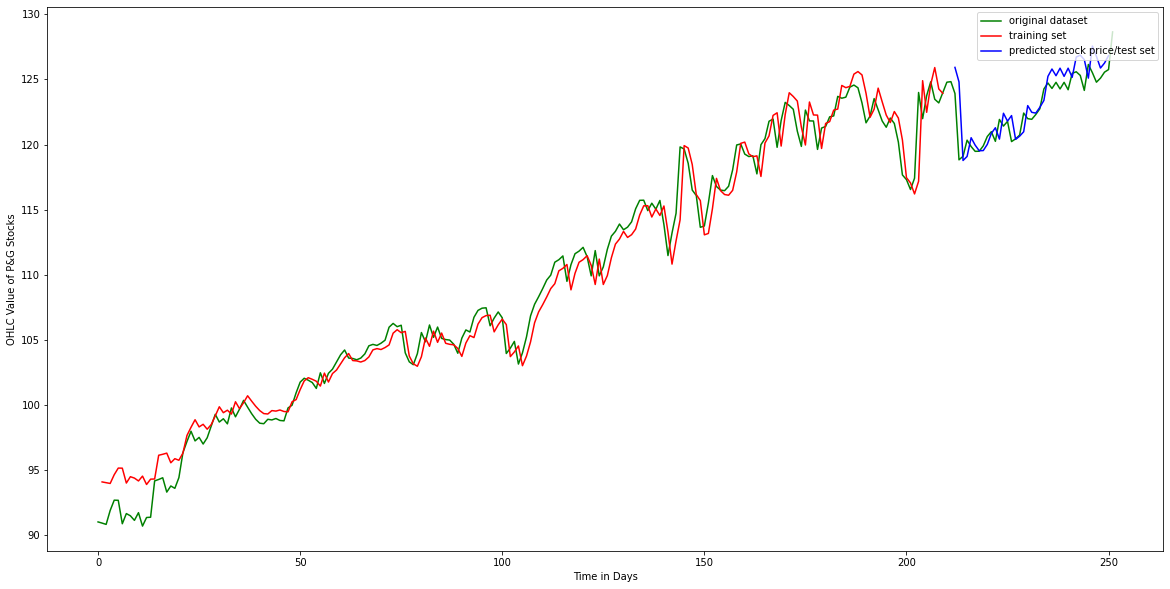

In [8]:
# CREATING SIMILAR DATASET TO PLOT TRAINING PREDICTIONS
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict)+step_size, :] = trainPredict

# CREATING SIMILAR DATASSET TO PLOT TEST PREDICTIONS
testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict

# DE-NORMALIZING MAIN DATASET 
OHLC_avg = scaler.inverse_transform(OHLC_avg)

# PLOT OF MAIN OHLC VALUES, TRAIN PREDICTIONS AND TEST PREDICTIONS

plt.figure(figsize=(20,10))
plt.plot(OHLC_avg, 'g', label = 'original dataset')
plt.plot(trainPredictPlot, 'r', label = 'training set')
plt.plot(testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper right')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of P&G Stocks')
plt.show()

**Backtesting of the Strategy**

In [9]:
backtest_data = pd.DataFrame()
backtest_data['P_Open'] = list(list(testPredict[:,0]))
btdata = df[(df["Date"] > test_start_date) & (df["Date"] < test_end_date)]
backtest_data['R_Open'] = list(btdata['Open'])
backtest_data['R_Close'] = list(btdata['Close'])
backtest_data['R_High'] = list(btdata['High'])
backtest_data['SP_Open'] = list(btdata['S&P 500-Open'])
backtest_data['SP_Close'] = list(btdata['S&P-Close'])
BackTest = bt.Back_Test(backtest_data)
r2 = sklearn.metrics.r2_score(backtest_data['R_Open'],backtest_data['P_Open'])
print("R_2 value Test: ",r2)
print("Sharpe Ratio : ",BackTest[0])
print("Treynor Ratio: ",BackTest[1])
print("Profit: ",BackTest[2])
print("Hit Rate: ",BackTest[3])

R_2 value Test:  0.5779113473196937
Sharpe Ratio :  1.2744547326980504
Treynor Ratio:  -2.9227612373919167
Profit:  0.4929728347322031
Hit Rate:  0.9130434782608695
